In [1]:
import torch
import tqdm
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [2]:
# GLOBALS
torch.manual_seed(0)
DIMENSIONS = 100 # State dimension
NUM_PARTICLES = 1000 # Number of particles
TIMESTEPS = 1000 # Number of timesteps

In [3]:
def prior(N=NUM_PARTICLES, D=DIMENSIONS, shuffle=True) -> torch.Tensor:
    """
    The prior is assumed to uniformly distribute over [0, 1]
    """
    particles = torch.rand((N, D))

    # manual modifications to the prior
    # slice the first 20% of the particles and set them to 1
    particles[:int(N * 0.2)] = 1

    # shuffle the particles
    if shuffle:
        indices = torch.randperm(N)
        particles = particles[indices]

    return particles


def transition(states):
    """
    The transition model.
    We will just add a small noise to each state.
    """
    noise = torch.normal(mean=0., std=0.1, size=states.size())
    return torch.clamp(states + noise, 0, 1) # ensure still within [0, 1]

    
def likelihood(state, D=DIMENSIONS):
    """
    Returns Euclidean distance to a specific target point
    """
    target = torch.tensor([0.5] * D) # target point at the center
    square_diff = (state - target) ** 2
    return torch.sqrt(square_diff.sum(dim=-1))


def smc(particles, timesteps=TIMESTEPS, num_samples=NUM_PARTICLES):
    """
    The SMC loop
    """

    for t in tqdm.tqdm(range(timesteps)):
        proposed_states = transition(states=particles)
        # we will apply the negative exponential to convert distances into weights,
        # which results in a higher weight to closer states because the close distance results in a large exponential value
        weights = torch.exp(-likelihood(proposed_states))
        weights /= weights.sum() # normalize weights
        indices = torch.multinomial(weights, num_samples=num_samples, replacement=True) # resampling
        states = proposed_states[indices]

    return states

In [4]:
# Generate particles from prior
particles_prior = prior(N=NUM_PARTICLES, D=DIMENSIONS, shuffle=True)

# Run SMC
particles_posterior = smc(particles_prior, timesteps=TIMESTEPS)

100%|██████████| 1000/1000 [00:00<00:00, 1476.19it/s]


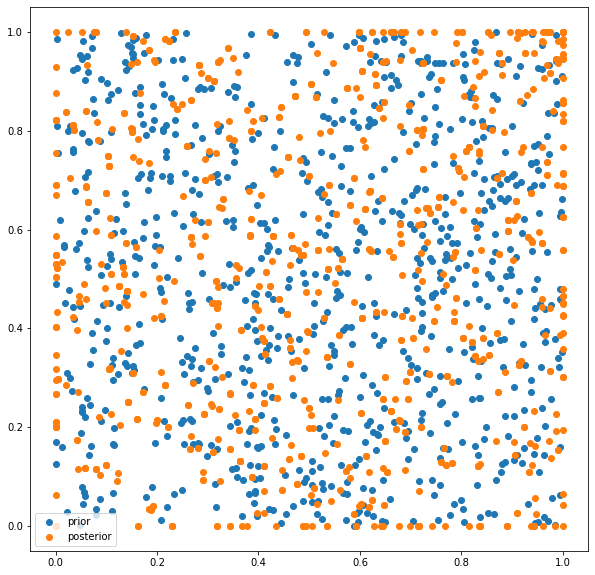

In [5]:
# Compare prior and posterior
# size
plt.figure(figsize=(10, 10))
plt.scatter(particles_prior[:, 0], particles_prior[:, 1], label='prior', )
plt.scatter(particles_posterior[:, 0], particles_posterior[:, 1], label='posterior')
plt.legend()
plt.show()

In [10]:
# plotly surface plot for the prior
fig = go.Figure(data=[go.Surface(z=particles_prior.numpy())])
# scale
# -1, 1
fig.update_layout(scene=dict(zaxis=dict(range=[-3, 3])))
fig.update_layout(title='Prior')
fig.show()


Prior samples:
tensor([[0.4061, 0.2215, 0.6596,  ..., 0.3797, 0.3699, 0.0791],
        [0.7649, 0.6315, 0.5268,  ..., 0.9454, 0.9678, 0.3171],
        [0.3451, 0.3825, 0.7840,  ..., 0.3375, 0.2744, 0.5224],
        ...,
        [0.1646, 0.9319, 0.7322,  ..., 0.2250, 0.0075, 0.7689],
        [0.2651, 0.2797, 0.2307,  ..., 0.1889, 0.0190, 0.1366],
        [0.3993, 0.4842, 0.7056,  ..., 0.7604, 0.5102, 0.3368]])


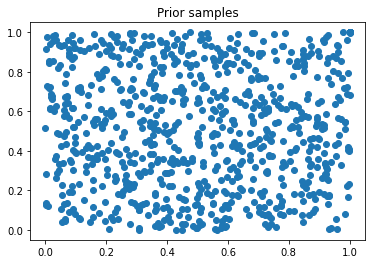

In [ ]:
# generate N prior samples
prior_samples = prior(N=1000)

print("Prior samples:")
print(prior_samples)

# visualize prior samples
plt.scatter(prior_samples[:, 0], prior_samples[:, 1])
plt.title("Prior samples")
plt.show()